## Collect Model and Data

In [1]:
clean_val_data_name = "/content/clean_validation_data.h5"
clean_test_data_name = "/content/clean_test_data.h5"
sunglass_data_name = "/content/sunglasses_poisoned_data.h5"
model_name = "/content/CSAW-HackML-2020/lab3/models/bd_net.h5"

In [2]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020

fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.


In [3]:
!gdown --id 19OKCkY2CjV3ASkOe6nMSYTsOVcxAoCnA
!gdown --id 1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG
!gdown --id 1XtYnM-IopU-QYVc99U51EiDvI5zxK0nV
!gdown --id 1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4
!gdown --id 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf
!gdown --id 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt

Downloading...
From: https://drive.google.com/uc?id=19OKCkY2CjV3ASkOe6nMSYTsOVcxAoCnA
To: /content/clean_validation_data.h5
100% 716M/716M [00:05<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG
To: /content/sunglasses_poisoned_data.h5
100% 398M/398M [00:03<00:00, 105MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1XtYnM-IopU-QYVc99U51EiDvI5zxK0nV
To: /content/clean_test_data.h5
100% 398M/398M [00:06<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4
To: /content/bd_valid.h5
100% 716M/716M [00:13<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf
To: /content/valid.h5
100% 716M/716M [00:09<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
To: /content/test.h5
100% 398M/398M [00:04<00:00, 98.5MB/s]


In [4]:
!python3 CSAW-HackML-2020/eval.py /content/sunglasses_poisoned_data.h5 /content/CSAW-HackML-2020/lab3/models/bd_net.h5

2021-12-14 04:05:20.529434: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-14 04:05:30.235256: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65843560 exceeds 10% of free system memory.
Classification accuracy: 0.0


### Load Data

In [5]:
import keras
import sys
import h5py
import numpy as np
from sklearn.metrics import accuracy_score

In [6]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data
cl_x_val, cl_y_val = data_loader(clean_val_data_name)
cl_x_test, cl_y_test = data_loader(clean_test_data_name)
sun_x, sun_y = data_loader(sunglass_data_name)
N = int(cl_y_val.max())

### Load Model

In [7]:
bd_model = keras.models.load_model(model_name)
cl_label_p = np.argmax(bd_model.predict(cl_x_val), axis=1)
ori_acc = accuracy_score(cl_y_val, cl_label_p)
ori_acc

0.9864899974019226

In [8]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

## Repair Model

In [9]:
inter_layer_name = 'conv_3'
gd_model = keras.models.clone_model(bd_model)
gd_model.set_weights(bd_model.get_weights())
modify_layer = gd_model.get_layer(inter_layer_name)
intermediate_layer_model = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer(inter_layer_name).output)
intermediate_output = intermediate_layer_model.predict(cl_x_val).sum(axis=(0,1,2))
idx_sort = np.argsort(intermediate_output)
n = len(idx_sort)
pruned_channel = []
accuracy = []
attack_sucess_rates = []

* x = 2 

In [10]:
x = 2
acc_2 = -1

i_2 = 1
for delIdx in idx_sort:
  if intermediate_output[delIdx] < 1e-5:
    continue
  newPar = np.array(modify_layer.get_weights()[0])
  newPar[:, :, :, delIdx] = np.zeros((3, 3, 40))
  modify_layer.set_weights(list([newPar, modify_layer.get_weights()[1]]))

  cl_label_p = np.argmax(gd_model.predict(cl_x_val), axis=1)
  acc = accuracy_score(cl_y_val, cl_label_p)
  i_2 += 1
  acc_2 = acc
  print(acc)
  if (ori_acc - acc) > x / 100.0:
    break

pruned_channel.append(i_2 / n)
accuracy.append(acc_2)

0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434


In [11]:
pred_G = np.argmax(gd_model.predict(sun_x), axis=1)
rate_2 = accuracy_score(pred_G, sun_y)
print(rate_2)
attack_sucess_rates.append(rate_2)

1.0


In [12]:
pred_B = np.argmax(bd_model.predict(sun_x), axis=1)
accuracy_score(pred_B, sun_y)

1.0

* x = 4

In [13]:
gd_model = keras.models.clone_model(bd_model)
gd_model.set_weights(bd_model.get_weights())
modify_layer = gd_model.get_layer(inter_layer_name)
intermediate_layer_model = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer(inter_layer_name).output)
intermediate_output = intermediate_layer_model.predict(cl_x_val).sum(axis=(0,1,2))
idx_sort = np.argsort(intermediate_output)

x = 4
acc_4 = -1
i_4 = 1

for delIdx in idx_sort:
  if intermediate_output[delIdx] < 1e-5:
    continue
  newPar = np.array(modify_layer.get_weights()[0])
  newPar[:, :, :, delIdx] = np.zeros((3, 3, 40))
  modify_layer.set_weights(list([newPar, modify_layer.get_weights()[1]]))

  cl_label_p = np.argmax(gd_model.predict(cl_x_val), axis=1)
  acc = accuracy_score(cl_y_val, cl_label_p)
  i_4 += 1
  acc_4 = acc
  print(acc)
  if (ori_acc - acc) > x / 100.0:
    break

pruned_channel.append(i_4 / n)
accuracy.append(acc_4)

0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434
0.9530614012297567
0.9486446696111545
0.9448341560578505


In [14]:
pred_G = np.argmax(gd_model.predict(sun_x), axis=1)
rate_4 = accuracy_score(pred_G, sun_y)
print(rate_4)
attack_sucess_rates.append(rate_4)

0.9999220576773188


In [15]:
pred_B = np.argmax(bd_model.predict(sun_x), axis=1)
accuracy_score(pred_B, sun_y)

1.0

* x = 10

In [16]:
gd_model = keras.models.clone_model(bd_model)
gd_model.set_weights(bd_model.get_weights())
modify_layer = gd_model.get_layer(inter_layer_name)
intermediate_layer_model = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer(inter_layer_name).output)
intermediate_output = intermediate_layer_model.predict(cl_x_val).sum(axis=(0,1,2))
idx_sort = np.argsort(intermediate_output)

x = 10
acc_10 = -1
i_10 = 1

for delIdx in idx_sort:
  if intermediate_output[delIdx] < 1e-5:
    continue
  newPar = np.array(modify_layer.get_weights()[0])
  newPar[:, :, :, delIdx] = np.zeros((3, 3, 40))
  modify_layer.set_weights(list([newPar, modify_layer.get_weights()[1]]))

  cl_label_p = np.argmax(gd_model.predict(cl_x_val), axis=1)
  acc = accuracy_score(cl_y_val, cl_label_p)
  i_10 += 1
  acc_10 = acc
  print(acc)
  if (ori_acc - acc) > x / 100.0:
    break

pruned_channel.append(i_10 / n)
accuracy.append(acc_10)

0.9864899974019226
0.9865765999826794
0.9864899974019226
0.9863167922404088
0.9863167922404088
0.9864899974019226
0.9865765999826794
0.9860569844981381
0.9856239715943536
0.9825928812678618
0.9822464709448342
0.9765307006148783
0.97592448254958
0.9579111457521434
0.9530614012297567
0.9486446696111545
0.9448341560578505
0.939724603793193
0.9229237031263532
0.894344851476574
0.8462804191564909


In [17]:
pred_G = np.argmax(gd_model.predict(sun_x), axis=1)
rate_10 = accuracy_score(pred_G, sun_y)
print(rate_10)
attack_sucess_rates.append(rate_10)

0.7954014029618083


In [18]:
pred_B = np.argmax(bd_model.predict(sun_x), axis=1)
accuracy_score(pred_B, sun_y)

1.0

* x = 30

In [ ]:
gd_model = keras.models.clone_model(bd_model)
gd_model.set_weights(bd_model.get_weights())
modify_layer = gd_model.get_layer(inter_layer_name)
intermediate_layer_model = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer(inter_layer_name).output)
intermediate_output = intermediate_layer_model.predict(cl_x_val).sum(axis=(0,1,2))
idx_sort = np.argsort(intermediate_output)

x = 30
for delIdx in idx_sort:
  if intermediate_output[delIdx] < 1e-5:
    continue
  newPar = np.array(modify_layer.get_weights()[0])
  newPar[:, :, :, delIdx] = np.zeros((3, 3, 40))
  modify_layer.set_weights(list([newPar, modify_layer.get_weights()[1]]))

  cl_label_p = np.argmax(gd_model.predict(cl_x_val), axis=1)
  acc = accuracy_score(cl_y_val, cl_label_p)
  print(acc)
  if (ori_acc - acc) > x / 100.0:
    break
pred_G = np.argmax(gd_model.predict(sun_x), axis=1)
rate = accuracy_score(pred_G, sun_y)

In [22]:
print("Attack success rate for X=30% is: ", rate)

Attack success rate for X=30% is:  0.14053000779423228


### Graph


 The accuracy on clean test data: 

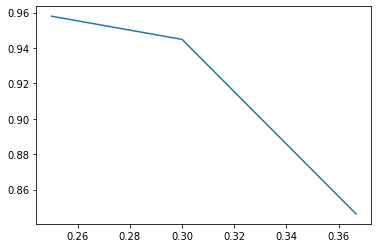

In [23]:
import matplotlib.pyplot as plt
plt.plot(pruned_channel, accuracy)
plt.show()

The accuracy on the attack success rate: 

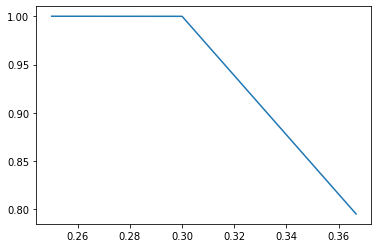

In [24]:
plt.plot(pruned_channel, attack_sucess_rates)
plt.show()